In [1]:
import import_ipynb
from CustomDataset import ControlsDataset

import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from tensorboardX import SummaryWriter

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


importing Jupyter notebook from CustomDataset.ipynb


In [2]:
if __name__ == "__main__":
    dataset = ControlsDataset()
    dataset.labels.num_categories = 21
    dataset.labels.transform.categorize(1.05, -1.05, 21)
    #dataset.images.set_grayscale(True)
    dataset.make_dataloaders()
    #dataloader = DataLoader(dataset, batch_size = 256, shuffle = True, num_workers = 0)

Total training stacks 7
Total validation stacks 2


In [3]:

from tqdm.notebook import tqdm_notebook
class ConvNet(nn.Module):
    def __init__(self,color_channels,outputs,dataset):
        super(ConvNet, self).__init__()
        
        self.channels = color_channels
        self.report_period = 20
        self.writer = SummaryWriter()
        self.start_epoch = 0
        self.infotype = dataset.labels.infotype
        self.dataset = dataset
        self.dataloader = dataset.dataloader
        
        img_size = torch.Size([1, color_channels, 170, 640]) # [batch_size, channels, height, width]
        empty = torch.zeros(img_size)
        # Conv2d(in_channels, out_channels, kernelSize, strides)
        # strideon train masks your variable train, and=3 ==> moving Filter 3 pixels between the application of kernel size
        
        self.conv1 = nn.Sequential(nn.Conv2d(color_channels, 16, 3, stride=2),
                                  nn.MaxPool2d(2),
                                  nn.ReLU())
        
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 3, stride=2),
                                  nn.MaxPool2d(2),
                                  nn.ReLU())
        
        self.conv3 = nn.Sequential(nn.Conv2d(32, 64, 3, stride=2),
                                   nn.ReLU())
        
        out = self.conv1(empty)
        out = self.conv2(out)
        units = self.conv3(out).numel()
        print("units after conv", units)
        
        self.fc = nn.Sequential(nn.Linear(units, units//2),
                                nn.ReLU(),
                                nn.Linear(units//2, units//4),
                                nn.ReLU(),
                                nn.Linear(units//4, outputs)) # <-- Returning predictions over classes
        
        #print("conv parameters: ", sum(p.numel() for p in self.conv.parameters()))
        print("fc parameters: ", sum(p.numel() for p in self.fc.parameters()))
    
    def forward(self, x):
        #x: batch, channel, height, width
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.reshape((batch_size,-1))
        out = self.fc(out)
        #print(out)
        return out
        
    def load(self,path):
        checkpoint = torch.load(path)
        self.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.start_epoch = checkpoint['epoch']
        
    def save(self,epoch,path):
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()}, 
            path)
        
    def fit(self, device, epochs, optimizer, criterion):
        self.train()
        self.optimizer = optimizer
        iter_no = 0
        percent = 0
        for epoch in range(self.start_epoch, epochs):
            for i_batch, sampled_batch in tqdm_notebook(enumerate(self.dataloader),
                                                       total=len(self.dataloader),
                                                       desc= str(percent)):
                #inputs and forward pass
                images = sampled_batch['image'].to(device).float()
                controls = sampled_batch['control'].to(device).long()
                controls = torch.flatten(controls)
                
                #backwards pass
                optimizer.zero_grad()
                prediction = self(images)
                #print(torch.argmax(prediction,dim=1))
                #print
                #print(controls)
                loss = criterion(prediction, controls)
                loss.backward()
                optimizer.step()

                iter_no += 1
                if iter_no % self.report_period == 0:
                    self.writer.add_scalar("Loss", loss.item(), iter_no)
                    print("saved to tensorboard")
                    self.save(epoch,"snapshots/{:.3f}_model.pt".format(loss.item()))

            out = "{0},{1}\tLoss:{2}\tAllocated:{3}GB\tCached:{4}GB\n"
            """
            print(out.format(str(epoch),
                            str(iter_no),
                            round(loss.item(),5),
                             'na', 'na'
                             #round(torch.cuda.memory_allocated(0)/1024**3,3),
                             #round(torch.cuda.memory_allocated(0)/1024**3,3)
                            ))
            """
            score = self.score(device,self.dataset)
            percent = round(score[1]/score[0],3)*100
            total,correct = score
            #print(correct)
            #print(prediction)
            #print("Accuracy: {}%".format(correct/total*100))
                
    def score(self,device,dataset, single_batch = False):
        self.eval()
        total = 0
        correct = 0
        for i_batch, sampled_batch in enumerate(dataset.validloader):
            images = sampled_batch['image'].to(device).float()
            controls = sampled_batch['control'].to(device).long()
            controls = torch.flatten(controls)
            prediction = self(images)

            maximum = torch.argmax(prediction,dim = 1)
            shared = maximum == controls
            shared = 1 * shared
            correct += int(torch.sum(shared))
            total += len(controls)
            if single_batch:
                return (total,correct)
        return (total,correct)
    
if __name__ == "__main__":
    if dataset.images.grayscale:
        channels = 1
    else:
        channels = 3

    net = ConvNet(channels, 21, dataset)

units after conv 4864
fc parameters:  14815765


cuda
units after conv 4864
fc parameters:  14815765
torch.Size([1, 21])
(16, 42, 159)
(32, 10, 39)
(64, 4, 19)


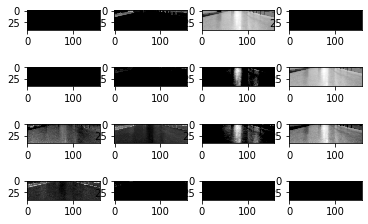

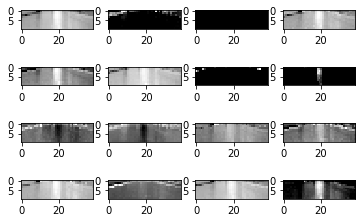

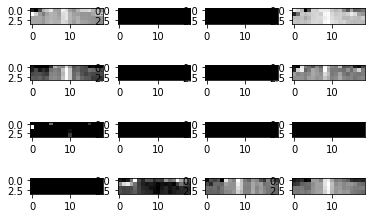

In [15]:
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    
    net = ConvNet(channels, 21, dataset).to(device)
    # Visualize feature maps
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    net.conv1.register_forward_hook(get_activation('conv1'))
    net.conv2.register_forward_hook(get_activation('conv2'))
    net.conv3.register_forward_hook(get_activation('conv3'))
    
    image = dataset[0]['image']
    
    image = torch.Tensor(image).to(device).float()
    
    image = image.reshape(1,3,170,640)
    output = net(image)
    
    print(output.shape)
    

    act = activation['conv1'].squeeze()
    act = act.cpu()
    act = act.detach().numpy()
    print(np.unique(act))
    
    print(act.shape)
    fig, axarr = plt.subplots(nrows = 4, ncols = 4)
    for x in range(4):
        for y in range(4):
            axarr[y][x].imshow(act[4*x + y], cmap='gray')
            
    act = activation['conv2'].squeeze()
    
    act = act.cpu()
    act = act.detach().numpy()
    
    print(act.shape)
    fig, axarr = plt.subplots(nrows = 4, ncols = 4)
    for x in range(4):
        for y in range(4):
            axarr[y][x].imshow(act[4*x + y], cmap='gray')
            
    act = activation['conv3'].squeeze()
    
    act = act.cpu()
    act = act.detach().numpy()
    
    print(act.shape)
    fig, axarr = plt.subplots(nrows = 4, ncols = 4)
    for x in range(4):
        for y in range(4):
            axarr[y][x].imshow(act[4*x + y], cmap='gray')